# **1. Imports, installations, settings**

In [2]:
# import os
# os.chdir("/home/yaroslav/FCUL/MARS_1.0")

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/lisboa_ciencia_de_dados/MARS_1.0')
!pip install -qq igraph ijson

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 11.1 MB/s eta 0:00:00


In [3]:
import ijson
import json
import gc
from project_cda.walker import Walker, RandomCrowd, RandomWalkerSettings, GraphLoader, Measure
import numpy as np
from project_cda.tag_formatter import set_log_level
from collections import Counter
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from random import sample

### We use graphs builded with Jaccard threshold 0.05, not sparsed. And also we use list of users which is cleaned for highest 5 percentiles for the feature "length of animelist".

In [4]:
users_cleaned_by_percentiles = 'user_dict_filtered.json'

EXPERIMENT_SIGNATURE = "Jac005_Full_Leiden_mod"

DATA_DIR = "data"
GRAPH_DIR = os.path.join(DATA_DIR, "graphs", EXPERIMENT_SIGNATURE)
USERS_DICT_FILE = os.path.join(DATA_DIR, "helpers", users_cleaned_by_percentiles)
EXPERIMENTS_DIR = os.path.join(DATA_DIR, "experiments")

print(GRAPH_DIR)
print(USERS_DICT_FILE)

data/graphs/Jac005_Full_Leiden_mod
data/helpers/user_dict_filtered.json


# **2. Single walkers creation. Random crowd settings.**

### Creation a list of **Walker** objects for every user.

In [5]:
set_log_level('WARNING')  # otherwise the outputs will be huge

with open(USERS_DICT_FILE, 'rb') as uf:
    parser = ijson.kvitems(uf, "")
    t = 0
    users = []
    for username, animelist in parser:
        walker = Walker(username, animelist)
        users.append(walker)
        t += 1
        # if t > 1000:
        #   break
        if t%10000 == 0:
            print(f"{t} users are ready to walk.")

10000 users are ready to walk.
20000 users are ready to walk.
30000 users are ready to walk.
40000 users are ready to walk.
50000 users are ready to walk.
60000 users are ready to walk.
70000 users are ready to walk.
80000 users are ready to walk.


### All our random walkers will use 'probabilistic' strategy.

In [6]:
random_crowd_settings = RandomWalkerSettings(strategy = 'probabilistic', prob_decay=2.0, top_k=50)
graph_loader = GraphLoader(GRAPH_DIR)

 # **3. Estimation of the satisfactory number of random walkers per user**

### Before the experiment we should estimate how many random walkers we need for every walker (special object for real user). To do this we will choose a random sample of walkers. Then we will launch the crowd of them twice and for each walk we save sets of visited links. Then calculate Perason coefficietn to estimate an overlap.

### We repeat this operation for 5, 10 and 15 random walkers per walker (user). And choose the number which allows to perform good stability.

In [10]:
for n_walkers in [5, 10, 15]:
  test_users = sample(users, 100)
  crowd_1, crowd_2 = Measure.stability_test(test_users, random_crowd_settings, graph_loader, n_walkers=n_walkers)

Stability Test (Run 1 vs Run 2): 100 users, walkers per user: 5)...
Run 1/2...
Run 2/2...

Results (Mean Similarity Run1 vs Run2):
User            | Run 1      | Run 2      | Diff      
-------------------------------------------------------
KissMyAnthia    | 0.0557     | 0.0543     | 0.0014
nyu6669         | 0.0448     | 0.0338     | 0.0110
P1pis1990       | 0.0473     | 0.0406     | 0.0067
-Videl-         | 0.0382     | 0.0237     | 0.0145
Lolimaster221   | 0.0570     | 0.0500     | 0.0070
Kana_Furinji    | 0.0668     | 0.0616     | 0.0052
Reeei           | 0.0311     | 0.0361     | 0.0050
Arikiel         | 0.0448     | 0.0423     | 0.0025
Darkvoid98      | 0.0360     | 0.0292     | 0.0068
Tarje           | 0.0663     | 0.0684     | 0.0021
-------------------------------------------------------
Среднее отклонение (MAE): 0.00838
Корреляция между запусками: 0.7784
[AVERAGE] Acceptable stability.
Stability Test (Run 1 vs Run 2): 100 users, walkers per user: 10)...
Run 1/2...
Run 2/2...


### We see that 10 random walkers per user give us acceptable result. Let us look at the some results of last two walks.

In [11]:
sample_from_users_results_1 = sample(sorted(crowd_1.metrics.items()), 2)
sample_from_users_results_2 = sample(sorted(crowd_2.metrics.items()), 2)

for crowd_sample in [sample_from_users_results_1, sample_from_users_results_2]:
  for user, data in crowd_sample:
    print(user, "\n---------------")
    for k, v in data.items():
      print(f"{k}: {v}")
    print("--------------------\n")

ne-ne3102 
---------------
length_of_history: 37
similarity_mean: 0.04571637008761189
similarity_std: 0.03291428266119953
similarity_values: [0.02994065494065494, 0.011506071288679984, 0.11043525052145742, 0.01715176715176715, 0.019305019305019305, 0.05317273795534666, 0.07587945087945087, 0.03578887328887329, 0.04054054054054054, 0.10947904426165295, 0.06902106902106903, 0.011261261261261262, 0.057975329109923104, 0.0, 0.044288481788481784]
cheating_factor: 0.8333333333333334
--------------------

ragnes_domi 
---------------
length_of_history: 96
similarity_mean: 0.045552812909639535
similarity_std: 0.013815697773230242
similarity_values: [0.028173845624734368, 0.036484847151252796, 0.05474134282806364, 0.053063372026519416, 0.03371072707281955, 0.04073975213014961, 0.06455796620639687, 0.04634739998365214, 0.02210427382898947, 0.05354290399681911, 0.04101921351127139, 0.057268353963325885, 0.04472756542162553, 0.03198927960833744, 0.07482135029063582]
cheating_factor: 0.378947368421

In [12]:
batch = [data["similarity_mean"] for username, data in crowd_2.metrics.items()]
del crowd_1, crowd_2; gc.collect()

0

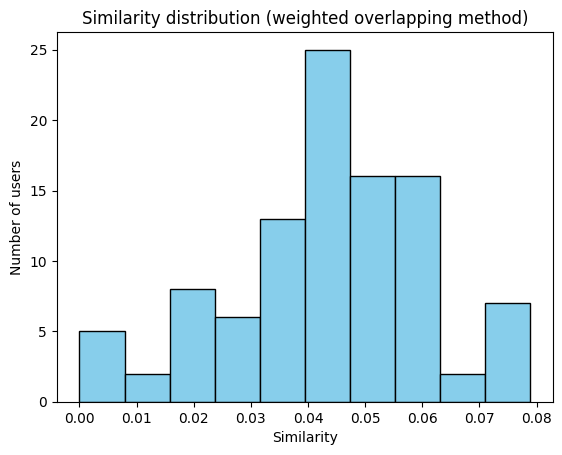

In [13]:
plt.hist(batch, bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Similarity")
plt.ylabel("Number of users")
plt.title("Similarity distribution (weighted overlapping method)")
plt.show()

# 4. **The experiment:**

### **Similarity calculation for the statistially meaningful amount of users (2000).** First we need to prepare sample stratified by the lebgth of anime history. Will bin them on 3 categories: Long (> 300), Short (< 50) and Medium.

In [14]:
df_users = pd.DataFrame([
    {'username': u.username, 'history_len': u.length}
    for u in users
])

bins = [0, 50, 300, np.inf]
labels = ['Light', 'Medium', 'Heavy']
df_users['category'] = pd.cut(df_users['history_len'], bins=bins, labels=labels)

SAMPLE_SIZE = 2500

stratified_sample_df = df_users.groupby('category', group_keys=False).apply(
    lambda x: x.sample(int(np.rint(SAMPLE_SIZE * len(x) / len(df_users))))
)

target_usernames = set(stratified_sample_df['username'])
users_for_experiment = [u for u in users if u.username in target_usernames]

print(f"Have {len(users_for_experiment)} uers for the experiment.")
print(stratified_sample_df['category'].value_counts(normalize=True))

Have 2499 uers for the experiment.
category
Medium    0.575430
Light     0.288515
Heavy     0.136054
Name: proportion, dtype: float64


/tmp/ipython-input-2668222903.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stratified_sample_df = df_users.groupby('category', group_keys=False).apply(
/tmp/ipython-input-2668222903.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample_df = df_users.groupby('category', group_keys=False).apply(


### Run cycle with using "Resume from Checkpoint" pattern. Because of possible Colab stops. If the Colab will have some troubles with our cycle, we can just relaunch the cells with settings (paragraphs 1-2) and the cell below, and start from the exact place we stopped.

In [7]:
OUTPUT_CSV = "users_similarity_experiment.csv"
OUTPUT_PATH = os.path.join(EXPERIMENTS_DIR, OUTPUT_CSV)

BATCH_SIZE = 500

# ==========================================
# STEP 1: Who is already processed?
# ==========================================
processed_usernames = set()

if os.path.exists(OUTPUT_PATH):
    print(f"Found {OUTPUT_CSV}...")
    try:
        df_existing = pd.read_csv(OUTPUT_PATH, usecols=["username"])
        processed_usernames = set(df_existing["username"].astype(str))
        print(f"Already processed: {len(processed_usernames)} users.")
    except Exception as e:
        print(f"Reading error: {e}")

# ==========================================
# STEP 2: Who needs to be processed?
# ==========================================
users_to_process = [u for u in users_for_experiment if str(u.username) not in processed_usernames]

print(f"Need to process: {len(users_to_process)} from {len(users_for_experiment)}")

# ==========================================
# STEP 3: Processing
# ==========================================

# Crowd for the current batch
for i in range(0, len(users_to_process), BATCH_SIZE):
    batch_users = users_to_process[i : i + BATCH_SIZE]

    batch_crowd = RandomCrowd(
        users=batch_users,
        n_walkers_per_user=10,
        settings=random_crowd_settings,
        data_folder=GRAPH_DIR
    )

    # Launch crowd
    try:
        batch_crowd.run()
        batch_crowd.evaluate()

        # write in append mode
        batch_data = []
        for username, data in batch_crowd.metrics.items():
            user_obj = next(u for u in batch_users if u.username == username)
            batch_data.append({
                "username": username,
                "length_of_history": data['length_of_history'],
                "cheating_factor": data['cheating_factor'],
                "similarity_mean": round(data['similarity_mean'], 4),
                "std_similarity": round(data['similarity_std'], 4),
            })

        df_batch = pd.DataFrame(batch_data)

        # Append mode
        need_header = not os.path.exists(OUTPUT_PATH)
        df_batch.to_csv(OUTPUT_PATH, mode='a', header=need_header, index=False)

        print(f"Batch {i} saved.")

    except Exception as e:
        print(f"Bad batch {i}: {e}")

    # memory cleaning
    del batch_crowd
    gc.collect()

Found users_similarity_experiment.csv...
Already processed: 2499 users.


NameError: name 'users_for_experiment' is not defined

### **4. Final similarity distribution**

Population similarity median: 0.0447
Population similarity mean: 0.0435
Population similarity std: 0.0184


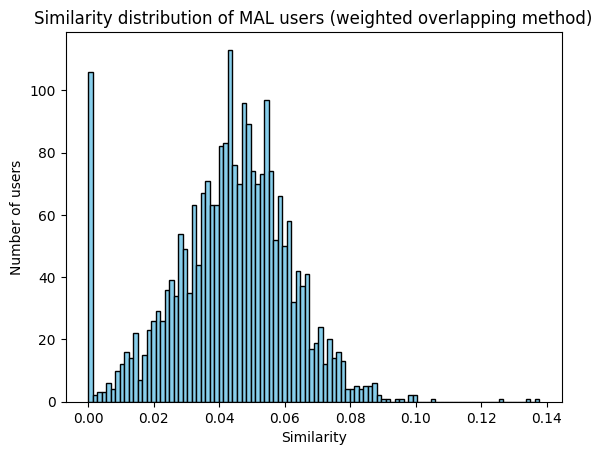

In [8]:
df = pd.read_csv(OUTPUT_PATH)

similarity_mean_values = df['similarity_mean'].values
print(f"Population similarity median: {np.median(similarity_mean_values):.4f}")
print(f"Population similarity mean: {np.mean(similarity_mean_values):.4f}")
print(f"Population similarity std: {np.std(similarity_mean_values):.4f}")

plt.hist(similarity_mean_values, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("Similarity")
plt.ylabel("Number of users")
plt.title("Similarity distribution of MAL users (weighted overlapping method)")
plt.show()

# We see that this method of predicting real user behaviour (pair "strategy-metrics") barely can catch patterns of the particular user and predict/determine his walk.